[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/ai-agents-lab-notebooks/blob/main/notebook_template.ipynb)


[![Lab Documentation and Solutions](https://img.shields.io/badge/Lab%20Documentation%20and%20Solutions-purple)](https://mongodb-developer.github.io/ai-agents-lab/)


# Step 1: Install libraries


In [1]:
! pip install -qU pymongo langchain-fireworks langgraph sentence_transformers


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


# Step 2: Setup prerequisites

Replace:

- `<MONGODB_URI>` with your **MongoDB connection string**
- `<FIREWORKS_API_KEY>` with your **Fireworks API key**

In [2]:
import os
from pymongo import MongoClient

In [7]:
# Retain the quotes ("") when pasting the URI
MONGODB_URI = "<MONGODB_URI>"
# Initialize a MongoDB Python client
mongodb_client = MongoClient(MONGODB_URI, appname="devrel.workshop.agents")
# Check the connection to the server
mongodb_client.admin.command("ping")

{'ok': 1.0,
 '$clusterTime': {'clusterTime': Timestamp(1729285364, 32),
  'signature': {'hash': b'\x08\x85\xc8x\x04\x98\x03\xeco!\xcf\xf6\xdf\xe4\xd2Y\x10I\x07)',
   'keyId': 7390069253761662978}},
 'operationTime': Timestamp(1729285364, 32)}

### **Do not change the values assigned to the variables below**

In [8]:
#  Database name
DB_NAME = "mongodb_agents_lab"
# Name of the collection with full articles
FULL_COLLECTION_NAME = "full_articles"
# Name of the collection for vector search
VS_COLLECTION_NAME = "chunked_articles"
# Name of the vector search index
VS_INDEX_NAME = "vector_index"

In [9]:
# Retain the quotes ("") when pasting the API key
os.environ["FIREWORKS_API_KEY"] = "<FIREWORKS_API_KEY"

# Step 3: Import data

Refer to the lab documentation for steps to important data for the agent to use.


# Step 4: Create a vector search index

In [56]:
# Create vector index definition specifying:
# path: Path to the embeddings field
# numDimensions: Number of embedding dimensions- depends on the embedding model used
# similarity: Similarity metric. One of cosine, euclidean, dotProduct.
model = {
    "name": VS_INDEX_NAME,
    "type": "vectorSearch",
    "definition": {
        "fields": [
            {
                "type": "vector",
                "path": "embedding",
                "numDimensions": 384,
                "similarity": "cosine",
            }
        ]
    },
}

In [18]:
vs_collection = mongodb_client[DB_NAME][VS_COLLECTION_NAME]

In [ ]:
# Create a vector search index with the above definition for the `collection` collection
vs_collection.create_search_index(model=model)

# Step 5: Create agent tools


In [5]:
from langchain.agents import tool
from sentence_transformers import SentenceTransformer
from typing import List

/Users/apoorva.joshi/Documents/ai-agents-lab-notebooks/.venv/lib/python3.12/site-packages/langchain/chains/api/base.py:56: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_community.utilities.requests import TextRequestsWrapper
/Users/apoorva.joshi/Documents/ai-agents-lab-notebooks/.venv/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/

### Vector Search

In [11]:
# Load the `gte-small` model using the Sentence Transformers library
embedding_model = SentenceTransformer("thenlper/gte-small")

In [12]:
# Define a function that takes a piece of text (`text`) as input, embeds it using the `embedding_model` instantiated above and returns the embedding as a list
# An array can be converted to a list using the `tolist()` method
def get_embedding(text: str) -> List[float]:
    """
    Generate the embedding for a piece of text.

    Args:
        text (str): Text to embed.

    Returns:
        List[float]: Embedding of the text as a list.
    """
    embedding = embedding_model.encode(text)
    return embedding.tolist()

In [113]:
# Define a tool to retrieve relevant documents for a user query using vector search
@tool
def get_information_for_question_answering(user_query: str) -> str:
    """
    Retrieve information using vector search to answer a user query.

    Args:
    user_query (str): The user's query string.

    Returns:
    str: The retrieved information formatted as a string.
    """

    # Generate embedding for the `user_query` using the `get_embedding` function defined in Step 5
    query_embedding = get_embedding(user_query)

    # Define an aggregation pipeline consisting of a $vectorSearch stage, followed by a $project stage
    # Set the number of candidates to 150 and only return the top 5 documents from the vector search
    # In the $project stage, exclude the `_id` field and include only the `body` field and `vectorSearchScore`
    # NOTE: Use variables defined previously for the `index`, `queryVector` and `path` fields in the $vectorSearch stage
    pipeline = [
        {
            "$vectorSearch": {
                "index": VS_INDEX_NAME,
                "path": "embedding",
                "queryVector": query_embedding,
                "numCandidates": 150,
                "limit": 5,
            }
        },
        {
            "$project": {
                "_id": 0,
                "body": 1,
                "score": {"$meta": "vectorSearchScore"},
            }
        },
    ]

    # Execute the aggregation `pipeline` and store the results in `results`
    results = vs_collection.aggregate(pipeline)
    context = "\n\n".join([doc.get("body") for doc in results])
    return context

### Get article content

In [14]:
full_collection = mongodb_client[DB_NAME][FULL_COLLECTION_NAME]

In [114]:
@tool
def get_article_content_for_summarization(user_query: str) -> str:
    """
    Retrieve article content based on provided title.

    Args:
    user_query (str): The user's query string i.e. title of the article.

    Returns:
    str: The content of the article.
    """
    projection = {"_id": 0, "body": 1}
    query = {"title": user_query}
    document = full_collection.find_one(query, projection)
    if document:
        return document["body"]
    else:
        return "Article not found"

In [115]:
# Create the list of tools
tools = [
    get_information_for_question_answering,
    get_article_content_for_summarization,
]

### Test out the tools


In [116]:
# Test out the `vector_search` tool
get_information_for_question_answering.invoke("Atlas Triggers")

'To create a new database trigger, you will need to:\n\n1. Click the **Data Services** tab in the top navigation of your screen if you haven\'t already navigated to Atlas.\n2. Click **Triggers** in the left-hand navigation.\n3. On the **Overview** tab of the **Triggers** page, click **Add Trigger** to open the trigger configuration page.\n4. Enter the configuration values for the trigger and click **Save** at the bottom of the page.\n\nPlease note that this trigger will make use of the *event ordering* as we want the operations to be processed according to when they were performed. \n\nThe trigger configuration values will look like this: \n\n using the UI, we need to:   \n\n1. Click the **Data Services** tab in the top navigation of your screen if you haven\'t already navigated to Atlas.\n\n2. Click **Functions** in the left navigation menu.\n\n# How to Send MongoDB Document Changes to a Slack Channel\n\nIn this tutorial, we will explore a seamless integration of your database with Sl

In [117]:
# Test out the `get_article` tool with article name "Using MongoDB Atlas Triggers to Summarize Airbnb Reviews with OpenAI"
get_article_content_for_summarization.invoke(
    "How to Model Your Documents for Vector Search"
)

'# How to Model Your Documents for Vector Search\n\nAtlas Vector Search was recently released, so let’s dive into a tutorial on how to properly model your documents when utilizing vector search to revolutionize your querying capabilities!\n\n## Data modeling normally in MongoDB\n\nVector search is new, so let’s first go over the basic ways of modeling your data in a MongoDB document before continuing on into how to incorporate vector embeddings. \n\nData modeling in MongoDB revolves around organizing your data into documents within various collections. Varied projects or organizations will require different ways of structuring data models due to the fact that successful data modeling depends on the specific requirements of each application, and for the most part, no one document design can be applied for every situation. There are some commonalities, though, that can guide the user. These are:\n\n 1. Choosing whether to embed or reference your related data. \n 2. Using arrays in a docu

# Step 6: Define graph state

In [21]:
from typing import Annotated
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict

In [22]:
class GraphState(TypedDict):
    messages: Annotated[list, add_messages]

# Step 7: Instantiate the LLM

In [118]:
from langchain_fireworks import ChatFireworks
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [119]:
llm = ChatFireworks(model="accounts/fireworks/models/firefunction-v2", temperature=0.0)

In [120]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "You are a helpful AI assistant."
            " You are provided with tools to answer questions and summarize articles related to MongoDB."
            " Use these tools to get the information required to answer the user query."
            " Do not re-run tools unless absolutely necessary."
            " If you are not able to get enough information using the tools, reply with I DON'T KNOW."
            " You have access to the following tools: {tool_names}."
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
llm_with_tools = prompt | llm.bind_tools(tools)

In [121]:
llm_with_tools.invoke(
    [
        "Give me a summary of the article titled How to Model Your Documents for Vector Search"
    ]
).tool_calls

[{'name': 'get_article_content_for_summarization',
  'args': {'user_query': 'How to Model Your Documents for Vector Search'},
  'id': 'call_uCbW6P1hq742nvFaH6lEyQJ2',
  'type': 'tool_call'}]

In [122]:
llm_with_tools.invoke(["What are Atlas Triggers?"]).tool_calls

[{'name': 'get_information_for_question_answering',
  'args': {'user_query': 'What are Atlas Triggers'},
  'id': 'call_H5TttXb423JfoulF1qVfPN3m',
  'type': 'tool_call'}]

# Step 8: Define graph nodes

In [123]:
from langchain_core.messages import ToolMessage

In [124]:
def agent(state: GraphState):
    messages = state["messages"]
    result = llm_with_tools.invoke(messages)
    return {"messages": [result]}

In [147]:
tools_by_name = {tool.name: tool for tool in tools}

In [148]:
def tool_node(state: GraphState):
    result = []
    tool_calls = state["messages"][-1].tool_calls
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

# Step 9: Define conditional edges

In [149]:
from langgraph.graph import END

In [150]:
def route_tools(state: GraphState):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    messages = state.get("messages", [])
    if len(messages) > 0:
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

# Step 10: Build the graph

In [151]:
from langgraph.graph import StateGraph, START
from IPython.display import Image, display

In [152]:
workflow = StateGraph(GraphState)

In [153]:
# Add nodes
workflow.add_node("agent", agent)
workflow.add_node("tools", tool_node)

In [154]:
# Add edges
workflow.add_edge(START, "agent")
workflow.add_edge("tools", "agent")
workflow.add_conditional_edges(
    "agent",
    route_tools,
    {"tools": "tools", END: END},
)

In [155]:
app = workflow.compile()

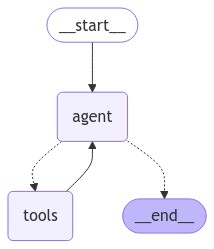

In [156]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Step 11: Execute the graph

In [157]:
def execute_graph(user_input: str):
    input = {"messages": [("user", user_input)]}
    for output in app.stream(input):
        for key, value in output.items():
            print(f"Node {key}:")
            print(value)
    print("---FINAL ANSWER---")
    print(value["messages"][-1].content)

In [158]:
execute_graph("What are MongoDB Atlas Triggers?")

Node agent:
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_YMwF0mh53h7CQDdmEi2a0aZZ', 'type': 'function', 'function': {'name': 'get_information_for_question_answering', 'arguments': '{"user_query": "What are MongoDB Atlas Triggers"}'}}]}, response_metadata={'token_usage': {'prompt_tokens': 586, 'total_tokens': 617, 'completion_tokens': 31}, 'model_name': 'accounts/fireworks/models/firefunction-v2', 'system_fingerprint': '', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-be66e92b-09d9-47b1-a776-54513ed1c111-0', tool_calls=[{'name': 'get_information_for_question_answering', 'args': {'user_query': 'What are MongoDB Atlas Triggers'}, 'id': 'call_YMwF0mh53h7CQDdmEi2a0aZZ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 586, 'output_tokens': 31, 'total_tokens': 617})]}
Node tools:
{'messages': [ToolMessage(content='# How to Send MongoDB Document Changes to a Slack Channel\n\nIn this tutorial, we will explore a seamless integr

In [159]:
execute_graph(
    "Give me a summary of the article titled How to Model Your Documents for Vector Search"
)

Node agent:
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_NWL9UoWSz69CJMuWgEp1L3M4', 'type': 'function', 'function': {'name': 'get_article_content_for_summarization', 'arguments': '{"user_query": "How to Model Your Documents for Vector Search"}'}}]}, response_metadata={'token_usage': {'prompt_tokens': 595, 'total_tokens': 628, 'completion_tokens': 33}, 'model_name': 'accounts/fireworks/models/firefunction-v2', 'system_fingerprint': '', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b7195585-a225-4c19-8c97-d1ca2343c6ef-0', tool_calls=[{'name': 'get_article_content_for_summarization', 'args': {'user_query': 'How to Model Your Documents for Vector Search'}, 'id': 'call_NWL9UoWSz69CJMuWgEp1L3M4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 595, 'output_tokens': 33, 'total_tokens': 628})]}
Node tools:
{'messages': [ToolMessage(content='# How to Model Your Documents for Vector Search\n\nAtlas Vector Search was recently re

# Step 12: Add memory to the agent

In [160]:
from langgraph.checkpoint.memory import MemorySaver

In [161]:
memory = MemorySaver()

In [162]:
app = workflow.compile(checkpointer=memory)

In [163]:
def execute_graph(thread_id, user_input: str):
    input = {"messages": [("user", user_input)]}
    config = {"configurable": {"thread_id": thread_id}}
    for output in app.stream(input, config):
        for key, value in output.items():
            print(f"Node {key}:")
            print(value)
    print("---FINAL ANSWER---")
    print(value["messages"][-1].content)

In [164]:
execute_graph(
    "1",
    "Give me a summary of the article titled How to Model Your Documents for Vector Search",
)

Node agent:
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_ruM1v67OQVDnTuJWyqMG1Vcw', 'type': 'function', 'function': {'name': 'get_article_content_for_summarization', 'arguments': '{"user_query": "How to Model Your Documents for Vector Search"}'}}]}, response_metadata={'token_usage': {'prompt_tokens': 595, 'total_tokens': 628, 'completion_tokens': 33}, 'model_name': 'accounts/fireworks/models/firefunction-v2', 'system_fingerprint': '', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f51e6ad0-707e-4a11-a72b-e2cfa7e0ba43-0', tool_calls=[{'name': 'get_article_content_for_summarization', 'args': {'user_query': 'How to Model Your Documents for Vector Search'}, 'id': 'call_ruM1v67OQVDnTuJWyqMG1Vcw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 595, 'output_tokens': 33, 'total_tokens': 628})]}
Node tools:
{'messages': [ToolMessage(content='# How to Model Your Documents for Vector Search\n\nAtlas Vector Search was recently re

In [165]:
execute_graph(
    "1",
    "What did I just ask you?",
)

Node agent:
{'messages': [AIMessage(content='You asked me to summarize the article titled "How to Model Your Documents for Vector Search".', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 2662, 'total_tokens': 2681, 'completion_tokens': 19}, 'model_name': 'accounts/fireworks/models/firefunction-v2', 'system_fingerprint': '', 'finish_reason': 'stop', 'logprobs': None}, id='run-6f7b4458-d4a4-468c-b61c-c602f121d4c6-0', usage_metadata={'input_tokens': 2662, 'output_tokens': 19, 'total_tokens': 2681})]}
---FINAL ANSWER---
You asked me to summarize the article titled "How to Model Your Documents for Vector Search".
